In [1]:
import numpy as np
import time
import cvxpy as cp
from copy import deepcopy
from typing import NamedTuple, List
from simulation_parameters import SimulationConfiguration, SimulationGeneralParameters, \
    EnvType, SimulationParameters, EnvParameters
from multireward_ope.tabular.envs.env import make_env, EnvParameters, EnvType, RiverSwimParameters
from multireward_ope.tabular.agents.make_agent import make_agent, \
    NoisyPolicyParameters, MRNaSPEParameters, AgentParameters, PolicyNoiseType
from multireward_ope.tabular.agents.base_agent import Experience
from multireward_ope.tabular.reward_set import RewardSet, RewardSetCircle, \
    RewardSetRewardFree
from multireward_ope.tabular.policy import Policy, PolicyFactory
from multireward_ope.tabular.utils import policy_evaluation
seed = 0 
discount_factor = 0.9
HORIZON = 50000
NUM_REWARDS = 30
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.random.seed(seed)

env_params = EnvParameters(
    env_type=EnvType.RIVERSWIM,
    parameters=RiverSwimParameters(num_states=10))

env = make_env(env = env_params)

reward_set = RewardSetCircle(env.dim_state, env.dim_action, 
        RewardSetCircle.RewardSetCircleConfig(np.zeros(env.dim_state), radius=1, p=2))
reward_set = RewardSetRewardFree(env.dim_state, env.dim_action, 
        RewardSetRewardFree.RewardSetFreeConfig())




In [ ]:

agent_params = AgentParameters(
        dim_state_space=env.dim_state,
        dim_action_space=env.dim_action,
        discount_factor=discount_factor,
        horizon=HORIZON,
        frequency_evaluation=500,
        delta=1e-2,
        epsilon=0.1,
        solver_type=cp.GUROBI)

results = {}

agents = [
# NoisyPolicyParameters(
#             agent_parameters=agent_params,
#             noise_type=PolicyNoiseType.VISITATION,
#             noise_parameter=0.3
#         ),
# NoisyPolicyParameters(
#             agent_parameters=agent_params,
#             noise_type=PolicyNoiseType.UNIFORM,
#             noise_parameter=0.3
#         ),
MRNaSPEParameters(
            agent_parameters=agent_params,
            period_computation_omega=5,
            alpha=0.99,
            beta=0.01
        )
]
for id_sim in range(1):
    policy_to_eval = PolicyFactory.random(env.dim_state, env.dim_action)

    eval_rewards = reward_set.sample(NUM_REWARDS)
    rewards = np.zeros((NUM_REWARDS, env.dim_state, env.dim_action))
    values = np.zeros((NUM_REWARDS, env.dim_state))
    for i in range(NUM_REWARDS):
        rewards[i, np.arange(env.dim_state), policy_to_eval] = eval_rewards[i]

        values[i] = env.policy_evaluation(rewards[i], discount_factor, policy_to_eval)
    for params in agents:
        agent = make_agent(params,
            policy=policy_to_eval,
            reward_set=reward_set)
        
        if params.name not in results:
            results[params.name] = []


        start_time = time.time()
        s = env.reset()
        res = []

        for t in range(HORIZON):
            a = agent.forward(s, t)
            next_state, _ = env.step(a)
            exp = Experience(s, a, next_state)
            reset = agent.backward(exp, t)

            s = env.reset() if reset else next_state

            # Evaluate the agent
            if (t +1) % agent_params.frequency_evaluation == 0:
                hat_values = np.array([
                    policy_evaluation(discount_factor, agent.empirical_transition(), R=rewards[r], policy=policy_to_eval)
                    for r in range(NUM_REWARDS)])

                err = np.linalg.norm(values - hat_values, ord=np.inf, axis=-1)
                #  {agent.state_action_visits}
                print(f'[{t}]  {agent.U_t} {agent.Z_t} - {agent.beta} - {err.mean()} - {err.std()} {agent.state_action_visits}')
                print('--------')
                res.append((err.mean(), err.std()))
                
        results[params.name].append(res)
        #         # Append results to be saved
        #         results.append(
        #                 Results(step=t, omega=deepcopy(agent.omega), total_state_visits=deepcopy(agent.total_state_visits),
        #                         last_visit= deepcopy(agent.last_visit), exp_visits=deepcopy(agent.exp_visits), V_res=V_res,
        #                         Q_res=Q_res, pi_res=pi_res, elapsed_time=time.time() - start_time))
        # return results

Restricted license - for non-production use only - expires 2026-11-23
[499]  15865.62429058957 0.03151467542922762 - 287.9168907578299 - 2.1596747880984806 - 1.0987499794991433 [[196.000 186.000]
 [53.000 44.000]
 [13.000 7.000]
 [1.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
--------
[999]  22155.728394076617 0.04513505411392171 - 339.15166728099257 - 2.065886707022661 - 1.1409800761602777 [[351.000 360.000]
 [108.000 100.000]
 [32.000 26.000]
 [8.000 11.000]
 [2.000 2.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
--------


c:\Users\russo\github\multi-reward-ope\.venv\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[1499]  26381.591697966673 0.056857827881386346 - 359.3337898702023 - 2.079874586465539 - 1.1589490518238417 [[536.000 545.000]
 [165.000 148.000]
 [46.000 34.000]
 [10.000 12.000]
 [2.000 2.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
--------
[1999]  29703.737448558695 0.06733159433097013 - 369.91341111675894 - 2.0822787630652955 - 1.1739725103278902 [[754.000 740.000]
 [214.000 181.000]
 [49.000 36.000]
 [10.000 12.000]
 [2.000 2.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
--------
[2499]  33465.22286166847 0.0747044180860225 - 383.0267104113702 - 2.075276125172186 - 1.177423063489956 [[950.000 933.000]
 [246.000 228.000]
 [65.000 49.000]
 [13.000 12.000]
 [2.000 2.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]
 [0.000 0.000]]
--------
[2999]  36513.15593560976 0.08216216657060381 - 396.2486354827742 - 2.054357048665486 - 1.1913092454783545 [[1132.000 1105.000]
 [289.000 286.000]
 [83.000 71.0

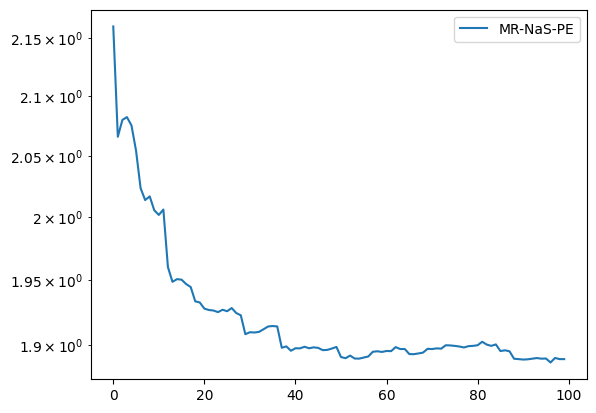

In [3]:
import matplotlib.pyplot as plt

for agent_name in results:
    data = np.array(results[agent_name])
    mu = data[:,:,0].mean(0)
    var = data[:,:,1] ** 2
    std = np.sqrt(var.mean(0) + data[:,:,0].var(0))
    plt.plot(data[:,:,0].mean(0), label=str(agent_name))
    # plt.fill_betweenx(range(100), mu-std, mu+std, alpha=0.2 )
    plt.yscale('log')
    plt.legend()

In [4]:
mu

array([2.160, 2.066, 2.080, 2.082, 2.075, 2.054, 2.024, 2.014, 2.017,
       2.006, 2.002, 2.006, 1.960, 1.949, 1.951, 1.950, 1.947, 1.945,
       1.933, 1.932, 1.928, 1.927, 1.926, 1.925, 1.927, 1.926, 1.928,
       1.924, 1.923, 1.908, 1.909, 1.909, 1.910, 1.912, 1.914, 1.914,
       1.914, 1.898, 1.899, 1.895, 1.897, 1.897, 1.898, 1.897, 1.898,
       1.897, 1.896, 1.896, 1.897, 1.898, 1.890, 1.890, 1.892, 1.889,
       1.889, 1.890, 1.891, 1.895, 1.895, 1.894, 1.895, 1.895, 1.898,
       1.897, 1.897, 1.893, 1.893, 1.893, 1.894, 1.897, 1.897, 1.897,
       1.897, 1.899, 1.899, 1.899, 1.899, 1.898, 1.899, 1.899, 1.900,
       1.902, 1.900, 1.899, 1.900, 1.895, 1.896, 1.895, 1.889, 1.889,
       1.889, 1.889, 1.889, 1.890, 1.889, 1.889, 1.886, 1.890, 1.889,
       1.889])